# Project Overview

Project goal is to generate a cleaned and merged data file in csv format, given 3 ficticious datasets, and provide notes as to what was found in the data, including any missing data.

## Provided Files:
1. Assessment file (sample_assessment.csv): Manhattan School District standardized test results - please include Math score.
2. Math product Usage file (sample_usage.csv): Please include both lessons completed and total minutes columns in the merged file. Students in grade levels 5, 6, 7, and 8 have access to the Math product.
3. SIS file (sample_sis.csv): Please include all information listed in this file (all students in grade levels 5, 6, 7, and 8) and all columns.



# Setup

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Allows plots to be rendered inside the notebook
%matplotlib inline

In [27]:
# Load files
sis_data = pd.read_csv('./resources/sample_sis.csv')
assessment_data = pd.read_csv('./resources/sample_assessment.csv')
usage_data = pd.read_csv('./resources/sample_usage.csv')

In [28]:
# Create list of dataframes for ease of programming
dataframes = [("SIS Data", sis_data), ("Assessment Data", assessment_data), ("Usage Data", usage_data)]


# Data Overview

In [29]:
# View headers
sis_data.head(5)

,student_id,grade_level,race_ethnicity,gender,Free/Reduced Price Lunch
0,1254353,7,White,Male,No
1,1254135,5,White,Male,NaN
2,1254423,8,Black/African American,Male,Reduced Price
3,1254598,8,White,Male,Free
4,1254562,6,Black/African American,Male,No


In [30]:
assessment_data.head(5)

,id,student_number,subject,score
0,1254397,54912357,ELA,190
1,1254204,54912164,ELA,567
2,1254785,54912745,ELA,390
3,1254308,54912268,Math,719
4,1254560,54912520,ELA,394


In [31]:
usage_data.head(5)

,student_id,lesson completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
0,1254110,13,level 2,level 1,level 3,level 2,47.808670
1,1254113,14,level 2,level 1,level4,level 1,156.792335
2,1254288,16,level 3,level 1,level 3,level 1,38.135959
3,1254095,15,level 3,level 1,level 1,level 1,18.257427
4,1254250,1,level 2,level 1,level 2,level 2,16.479016


## Cursory Observations
- Relationship column between files is Student ID (student_id).
    - While the Usage & SIS files have a clearly labeled student_id column, the Assessment file has two possible columns that could be Student ID, either id or student_number. 
    - All id-related columns have 7 digits, but the id column in the Assessments file has similar leading numbers as the student_id columns in the other two files.
- Additional header observations:
    - File headers have incongruent formats- spacing vs underscores, mixed casing, includes slash character. 
    - The directions require “lessons completed”, whereas the column header is “lesson completed”.
- NaN value is present in Free/Reduced Price Lunch.
- Benchmark value format is inconsistent.
- Since Math scores are the focus, I'll need to check & filter the subject column.
- Since Grade Level determines access to the Usage file, I'll need to check and filter the grade_level column.

In [60]:
# Normalize headers

custom_mappings = {
    'lesson_completed': 'lessons_completed',
    'id': 'student_id'
}

for name, df in dataframes:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_').str.replace(r'[^\w]', '')
    if custom_mappings:
        df.rename(columns=custom_mappings, inplace=True)


# Analyze Data in Preparation for Merge

In [52]:
for name, df in dataframes:
    print(name, "Info:")
    df.info()
    print("\n")

SIS Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   student_id                783 non-null    int64 
 1   grade_level               783 non-null    int64 
 2   race_ethnicity            736 non-null    object
 3   gender                    783 non-null    object
 4   free_reduced_price_lunch  669 non-null    object
dtypes: int64(2), object(3)
memory usage: 30.7+ KB


Assessment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      1280 non-null   int64 
 1   student_number  1280 non-null   int64 
 2   subject         1280 non-null   object
 3   score           1280 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 40.1+ KB


Usage

<div class="alert alert-block alert-success">
<b>Data Type Consistency</b> Column Data Types are as expected. Student ID's and other int-expected columns are integers. Columns with expected string values are objects. Total minutes are floats.
</div>

<div class="alert alert-block alert-warning">
<b>Null or NaN:</b> I can see there are Null or NaN values in the SIS Data for columns race/ethnicity and free/reduced price lunch, but these are non-essential columns.
</div>

## Check ID Columns

In [38]:
# SIS IDs
sis_data.describe()['student_id']

count    7.830000e+02
mean     1.254464e+06
std      2.261769e+02
min      1.254073e+06
25%      1.254268e+06
50%      1.254464e+06
75%      1.254660e+06
max      1.254855e+06
Name: student_id, dtype: float64

In [42]:
# Assessment IDs
assessment_data.describe()['student_id']

count    1.280000e+03
mean     1.254502e+06
std      1.848241e+02
min      1.254183e+06
25%      1.254343e+06
50%      1.254502e+06
75%      1.254662e+06
max      1.254822e+06
Name: student_id, dtype: float64

In [43]:
# Usage IDs
usage_data.describe()['student_id']

count    3.490000e+02
mean     1.254239e+06
std      1.008919e+02
min      1.254065e+06
25%      1.254152e+06
50%      1.254239e+06
75%      1.254326e+06
max      1.254413e+06
Name: student_id, dtype: float64

<div class="alert alert-block alert-success">
<b>No Messy Data in ID Columns</b> There are no outliers, negatives, zeros, or placeholder data in the Student ID columns in any data set.
</div>

<div class="alert alert-block alert-info">
<b>Different IDs</b> Min & max ID's are different in all dataframes indicating different student exist in both. However, this is to be expected since Assessement Data includes ELA, while Usage Data is Math only.
</div>

### Check ID Columns for Duplicates

In [59]:
for name, df in dataframes:
    print(f"{name} has duplicates?: {df['student_id'].duplicated().any()}")

SIS Data has duplicates?: False
Assessment Data has duplicates?: True
Usage Data has duplicates?: False


<div class="alert alert-block alert-info">
<b>Duplicates as Expected:</b> Assessment Data has student scores for both Math & ELA. SIS & Usage have no duplicates. Assessment Data will need to be handled accordingly.
</div>

## Check Other Columns

In [53]:
# Numerical columns to check
specific_columns = ['grade_level', 'score', 'lessons_completed', 'total_minutes', 'student_number']

# Check specific columns for values less than 0
for name, df in dataframes:
    print(f"Checking {name}...")
    found = False
    for column in specific_columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            if (df[column] < 0).any():
                print(f"  Column '{column}' in {name} has values less than 0.")
                found = True

    if (not found):
        print("No numerical inconsistencies found.")

Checking SIS Data...
No numerical inconsistencies found.
Checking Assessment Data...
No numerical inconsistencies found.
Checking Usage Data...
No numerical inconsistencies found.


In [55]:
# Check SIS Grade Levels are as expected (5-8)
print(sis_data['grade_level'].unique())

[7 5 8 6]


In [56]:
# Check Assessment Subjects are as expected (Math or ELA)
print(assessment_data['subject'].unique())

['ELA' 'Math']


## Handle Assessment Data

In [61]:
# Split Assessment Data into Math vs ELA
assessment_ela = assessment_data[assessment_data['subject'] == 'ELA']
assessment_math = assessment_data[assessment_data['subject'] == 'Math']

assessment_math.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 3 to 1279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      640 non-null    int64 
 1   student_number  640 non-null    int64 
 2   subject         640 non-null    object
 3   score           640 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 25.0+ KB


In [62]:
# Create list of new dataframes for ease of programming
math_dataframes = [("SIS Data", sis_data), ("Assessment Data", assessment_math), ("Usage Data", usage_data)]


In [63]:
for name, df in math_dataframes:
    print(f"{name} has duplicates?: {df['student_id'].duplicated().any()}")

SIS Data has duplicates?: False
Assessment Data has duplicates?: False
Usage Data has duplicates?: False


<div class="alert alert-block alert-success">
<b>No Duplicate IDs Found</b> No duplicates found after removing ELA from Assessments
</div>

In [68]:
# Comparing Intersections, Differences between data
assessment_ids = np.array(assessment_math['student_id'])
usage_ids = np.array(usage_data['student_id'])
sis_ids = np.array(sis_data['student_id'])

sis_assess_intersection = np.intersect1d(assessment_ids, sis_ids)
usage_assess_intersection = np.intersect1d(assessment_ids, usage_ids)
# print("Common IDs between assessment and SIS:", len(sis_assess_intersection))
# print("Common IDs between assessment and Usage:", len(usage_assess_intersection))

print("IDs in Assessment but not in SIS:", len(np.setdiff1d(assessment_ids, sis_ids)))
print("IDs in Usage but not in SIS:", len(np.setdiff1d(usage_ids, sis_ids)))

print("IDs in SIS but not in Assessment:", len(np.setdiff1d(sis_ids, assessment_ids)))
print("IDs in SIS but not in Usage:", len(np.setdiff1d(sis_ids, usage_ids)))

print("IDs in Assessment but not in Usage:", len(np.setdiff1d(assessment_ids, usage_ids)))
print("IDs in Usage but not in Assessment:", len(np.setdiff1d(usage_ids, assessment_ids)))


IDs in Assessment but not in SIS: 0
IDs in Usage but not in SIS: 8
IDs in SIS but not in Assessment: 143
IDs in SIS but not in Usage: 442
IDs in Assessment but not in Usage: 409
IDs in Usage but not in Assessment: 118


## Handle Usage Data

In [71]:
# Check Usage Benchmarks
for col in ['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level']:
    print(f"Unique values in {col}: {usage_data[col].unique()}")

Unique values in benchmark_1_level: ['level 2' 'level 3' 'level 1' 'level4']
Unique values in benchmark_2_level: ['level 1' 'level 2' 'level 3' 'level4']
Unique values in benchmark_3_level: ['level 3' 'level4' 'level 1' 'level 2']
Unique values in benchmark_4_level: ['level 2' 'level 1' 'level4' 'level 3']


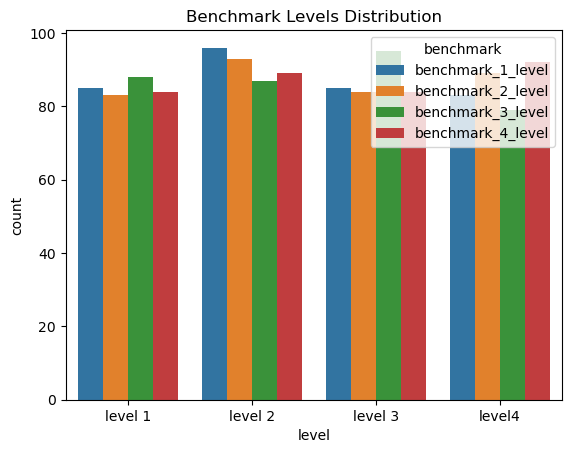

In [72]:
# Benchmark level distribution
melted = usage_data.melt(id_vars=['student_id'], 
                       value_vars=['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level'], 
                       var_name='benchmark', 
                       value_name='level')

sb.countplot(data=melted, x='level', hue='benchmark', order=['level 1', 'level 2', 'level 3', 'level4'])
plt.title("Benchmark Levels Distribution")
plt.show()


# Merge Data
- Use SIS data as base, into which other data is merged

In [69]:
# Merge SIS and Usage
merged_df = sis_data.merge(usage_data, on='student_id', how='left')

# Merge the result with Assessment
merged_df = merged_df.merge(assessment_math, on='student_id', how='left')

# Display the merged dataset
print(merged_df.head())


   student_id  grade_level          race_ethnicity gender  \
0     1254353            7                   White   Male   
1     1254135            5                   White   Male   
2     1254423            8  Black/African American   Male   
3     1254598            8                   White   Male   
4     1254562            6  Black/African American   Male   

  free_reduced_price_lunch  lessons_completed benchmark_1_level  \
0                       No               24.0           level 2   
1                      NaN                1.0           level 2   
2            Reduced Price                NaN               NaN   
3                     Free                NaN               NaN   
4                       No                NaN               NaN   

  benchmark_2_level benchmark_3_level benchmark_4_level  total_minutes  \
0           level 2           level 2           level 2      21.040558   
1           level 2           level 3           level 3      53.124390   
2       

# Scratch Pad
### Considerations
- Pull student_numbers from ELA table to merged table?
- 

In [29]:
# Identify Duplicate ID rows

assessment_duplicate_rows = assessment_data[assessment_data.duplicated(subset=['id'], keep=False)]
print(assessment_duplicate_rows)

           id  student_number subject  score
0     1254397        54912357     ELA    190
1     1254204        54912164     ELA    567
2     1254785        54912745     ELA    390
3     1254308        54912268    Math    719
4     1254560        54912520     ELA    394
...       ...             ...     ...    ...
1275  1254205        54912165     ELA    615
1276  1254564        54912524     ELA    382
1277  1254424        54912384    Math    750
1278  1254358        54912318     ELA    304
1279  1254500        54912460    Math    105

[1280 rows x 4 columns]


In [49]:
for name, df in dataframes:
    print(f"Checking {name}...")
    found = False
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        if (df[column] < 0).any():
            print(f"  Column '{column}' in {name} has values less than 1.")
            found = True

    
    if (not found):
        print("No inconsistencies found.")

Checking SIS Data...
No inconsistencies found.
Checking Assessment Data...
No inconsistencies found.
Checking Usage Data...
No inconsistencies found.


In [24]:
# Confirm ID columns have no negative or zero values
sis_invalid_ids = sis_data['student_id'] <= 0
print("SIS Invalid IDs:", sis_data[sis_invalid_ids])

assessment_invalid_ids = assessment_data['id'] <= 0
print("Assessment Invalid IDs:", assessment_data[assessment_invalid_ids])

assessment_invalid_nums = assessment_data['student_number'] <= 0
print("Assessment Invalid Nums:", assessment_data[assessment_invalid_nums])

usage_invalid_ids = usage_data['student_id'] <= 0
print("Usage Invalid IDs:", usage_data[usage_invalid_ids])

SIS Invalid IDs: Empty DataFrame
Columns: [student_id, grade_level, race_ethnicity, gender, Free/Reduced Price Lunch]
Index: []
Assessment Invalid IDs: Empty DataFrame
Columns: [id, student_number, subject, score]
Index: []
Assessment Invalid Nums: Empty DataFrame
Columns: [id, student_number, subject, score]
Index: []
Usage Invalid IDs: Empty DataFrame
Columns: [student_id, lesson completed, benchmark_1_level, benchmark_2_level, benchmark_3_level, benchmark_4_level, total_minutes]
Index: []


In [12]:
# Total problematic values (NaN + blank)
total_issues = (assessment_data['id'].isnull() | assessment_data['id'].astype(str).str.strip().eq('')).sum()
print("Total number of problematic values:", total_issues)

Total number of problematic values: 0
